# Entropy Simulation

## Set up

In [1]:
### Libraries ###
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

### Append path ###
import sys
sys.path.append('src/')

### Imports ###
from utils.data_handler import load_data
from sklearn.metrics import accuracy_score
from utils.models import RandomForestWrapper

In [2]:
# --- Simulation Parameters ---
DATASET_NAME = "MONK1" 
N_UNIVERSE = 100000     
N_ESTIMATE = 1000       
RANDOM_STATE = 42

In [3]:
### Vote Entropy Function ###
def _calculate_vote_entropy(committee_preds: pd.DataFrame) -> np.ndarray:
    proportions = committee_preds.apply(
        lambda row: row.value_counts(normalize=True), axis=1
    ).fillna(0)
    entropy = -np.sum(proportions * np.log2(proportions + 1e-9), axis=1)
    return entropy.values

## Load Data

In [4]:
print(f"--- Starting Entropy Estimation Study for Dataset: {DATASET_NAME} ---")

print("[1/5] Loading data...")
df = load_data(DATASET_NAME, base_path=Path("src/data/processed"))
X = df.drop(columns="Y")
y = df["Y"]

--- Starting Entropy Estimation Study for Dataset: MONK1 ---
[1/5] Loading data...


## Generate Universe of Trees

In [ ]:
### Universe ###
print(f"[2/5] Generating 'universe' of {N_UNIVERSE} trees...")
universe_model_wrapper = RandomForestWrapper(n_estimators=N_UNIVERSE, random_state=RANDOM_STATE)
universe_model_wrapper.fit(X, y)
universe_model = universe_model_wrapper.model # Get the underlying sklearn model

### Ground truth entropy ####
print("[3/5] Calculating 'ground truth' entropy from UNIQUE patterns...")
universe_preds_df = universe_model_wrapper.get_raw_ensemble_predictions(X)

# ### Uncomment this section to have the true universe only contain unique patterns ###
# universe_preds_df = universe_preds_df.T.drop_duplicates().T
# print(f"  -> Found {len(universe_preds_df.columns)} unique tree patterns out of {N_UNIVERSE}.")

true_entropy = _calculate_vote_entropy(universe_preds_df)
print(f"  -> Ground truth entropy calculated.")

[2/5] Generating 'universe' of 100000 trees...
[3/5] Calculating 'ground truth' entropy from UNIQUE patterns...
  -> Ground truth entropy calculated.


## Filter Random Forest

### DUREAL and UNREAL Proxies

In [6]:
print("[4/5] Creating filtered committees...")

### Evaluate each individual tree from the universe ###
tree_accuracies = []
for i, tree in enumerate(universe_model.estimators_):
    acc = accuracy_score(y, tree.predict(X.values))
    tree_accuracies.append((acc, tree))

### DUREAL PROXY ###
# Sort the trees by accuracy and select the top N_ESTIMATE
tree_accuracies.sort(key=lambda x: x[0], reverse=True)
best_trees_committee = [tree for acc, tree in tree_accuracies[:N_ESTIMATE]]
print(f"  -> Found {len(best_trees_committee)} top-performing trees.")

### UNREAL PROXY ###
# Get the prediction pattern for each of the best-performing trees
best_tree_preds = np.array([tree.predict(X.values) for tree in best_trees_committee]).T
best_tree_preds_df = pd.DataFrame(best_tree_preds)
unique_indices = best_tree_preds_df.T.drop_duplicates().index

# Create the new committee using only the unique-pattern trees (UNREAL Proxy)
unique_best_trees_committee = [best_trees_committee[i] for i in unique_indices]
print(f"  -> After de-duplication, found {len(unique_best_trees_committee)} unique top-performing trees.")

[4/5] Creating filtered committees...
  -> Found 1000 top-performing trees.
  -> After de-duplication, found 85 unique top-performing trees.


### Random Forest

In [7]:
print("[5/5] Creating 'Randomly Sampled RF' committee...")

# Randomly sample N_ESTIMATE trees from the original universe
random.seed(RANDOM_STATE)
randomly_sampled_committee = random.sample(universe_model.estimators_, N_ESTIMATE)
print(f"  -> Randomly sampled {len(randomly_sampled_committee)} trees from the universe.")

[5/5] Creating 'Randomly Sampled RF' committee...
  -> Randomly sampled 1000 trees from the universe.


In [8]:
# --- Calculate Entropy for all three committees ---
# 1. Randomly Sampled RF
random_preds_df = pd.DataFrame(np.array([tree.predict(X.values) for tree in randomly_sampled_committee]).T)
random_sampled_entropy_estimate = _calculate_vote_entropy(random_preds_df)

# 2. Filtered RF (with duplicates) - DUREAL Proxy
filtered_preds_df = pd.DataFrame(np.array([tree.predict(X.values) for tree in best_trees_committee]).T)
filtered_entropy_estimate = _calculate_vote_entropy(filtered_preds_df)

# 3. Unique Filtered RF (de-duplicated) - UNREAL Proxy
unique_filtered_preds_df = pd.DataFrame(np.array([tree.predict(X.values) for tree in unique_best_trees_committee]).T)
unique_filtered_entropy_estimate = _calculate_vote_entropy(unique_filtered_preds_df)


# --- Compare all estimates to the true entropy using MSE ---
mse_random_sampled_rf = np.mean((random_sampled_entropy_estimate - true_entropy)**2)
mse_filtered_rf = np.mean((filtered_entropy_estimate - true_entropy)**2)
mse_unique_filtered_rf = np.mean((unique_filtered_entropy_estimate - true_entropy)**2)

print("\n--- Comparison Results ---")
print(f"Mean Squared Error (Randomly Sampled RF vs. True): {mse_random_sampled_rf:.6f}")
print(f"Mean Squared Error (DUREAL Proxy vs. True):        {mse_filtered_rf:.6f}")
print(f"Mean Squared Error (UNREAL Proxy vs. True):        {mse_unique_filtered_rf:.6f}")


--- Comparison Results ---
Mean Squared Error (Randomly Sampled RF vs. True): 0.000773
Mean Squared Error (DUREAL Proxy vs. True):        0.147954
Mean Squared Error (UNREAL Proxy vs. True):        0.136331


## Plot

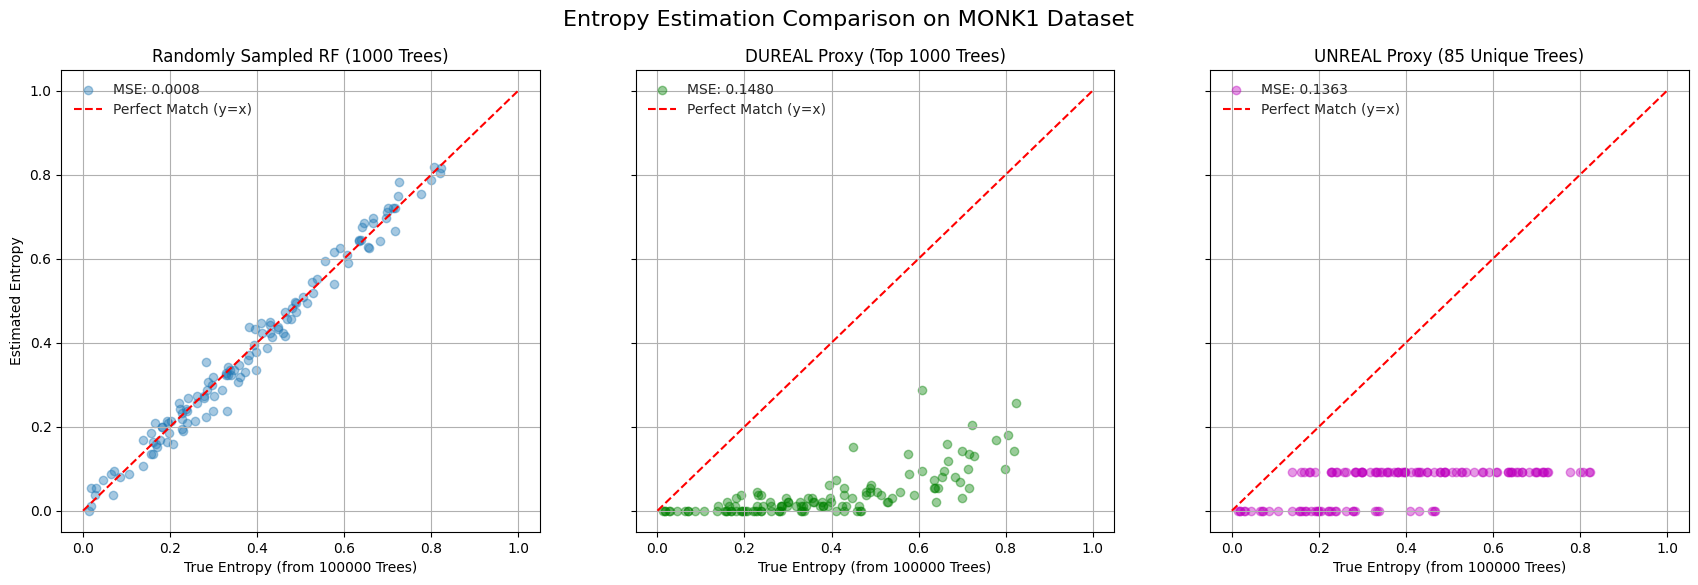

In [9]:
# --- Plot the results ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6), sharex=True, sharey=True)
fig.suptitle(f'Entropy Estimation Comparison on {DATASET_NAME} Dataset', fontsize=16)
plt.style.use('seaborn-v0_8-whitegrid')

# Plot for Randomly Sampled RF
ax1.scatter(true_entropy, random_sampled_entropy_estimate, alpha=0.4, label=f'MSE: {mse_random_sampled_rf:.4f}')
ax1.plot([0, 1], [0, 1], 'r--', label='Perfect Match (y=x)')
ax1.set_title(f"Randomly Sampled RF ({N_ESTIMATE} Trees)")
ax1.set_xlabel(f"True Entropy (from {N_UNIVERSE} Trees)")
ax1.set_ylabel("Estimated Entropy")
ax1.grid(True)
ax1.legend()

# Plot for Filtered RF (with duplicates) - DUREAL Proxy
ax2.scatter(true_entropy, filtered_entropy_estimate, alpha=0.4, color='g', label=f'MSE: {mse_filtered_rf:.4f}')
ax2.plot([0, 1], [0, 1], 'r--', label='Perfect Match (y=x)')
ax2.set_title(f"DUREAL Proxy (Top {N_ESTIMATE} Trees)")
ax2.set_xlabel(f"True Entropy (from {N_UNIVERSE} Trees)")
ax2.grid(True)
ax2.legend()

# Plot for Unique Filtered RF (de-duplicated) - UNREAL Proxy
ax3.scatter(true_entropy, unique_filtered_entropy_estimate, alpha=0.4, color='m', label=f'MSE: {mse_unique_filtered_rf:.4f}')
ax3.plot([0, 1], [0, 1], 'r--', label='Perfect Match (y=x)')
ax3.set_title(f"UNREAL Proxy ({len(unique_best_trees_committee)} Unique Trees)")
ax3.set_xlabel(f"True Entropy (from {N_UNIVERSE} Trees)")
ax3.grid(True)
ax3.legend()

plt.show()